In [6]:
# ML approach for time series data


In [7]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from window_slider import Slider as WindowSlider

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


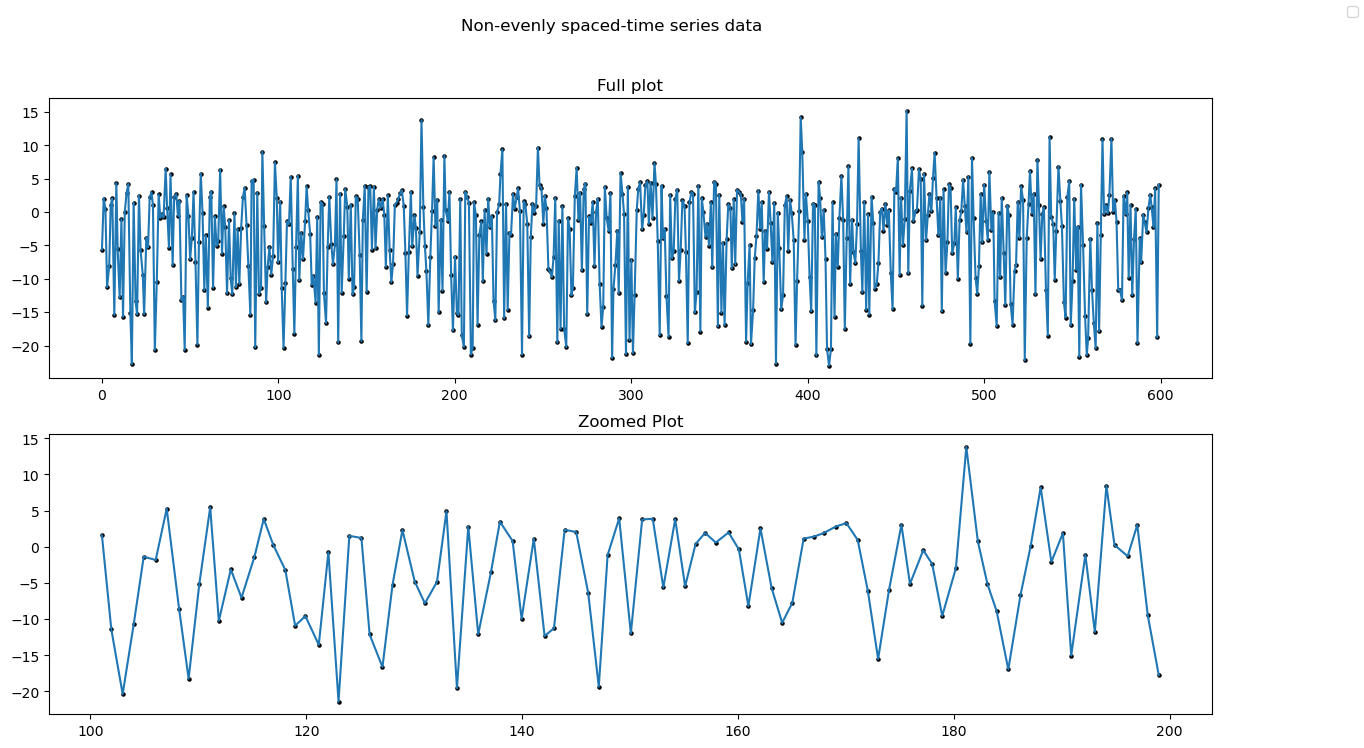

In [33]:
### data creation

N = 600

t = np.arange(0, N, 1).reshape(-1,1)
t = np.array([t[i] + np.random.rand(1)/4 for i in range(len(t))])
t = np.array([t[i] - np.random.rand(1)/7 for i in range(len(t))])
t = np.array(np.round(t, 2))

x1 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)
x2 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)
x3 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)

n = np.round((np.random.random(N) * 2).reshape(-1,1), 2)

y = np.array([((np.log(np.abs(2 + x1[t])) - x2[t-1]**2) + 0.02*x3[t-3]*np.exp(x1[t-1])) for t in range(len(t))])
y = np.round(y+n, 2)

# plt.plot(t, y)
# plt.show()
fig, axs = plt.subplots(nrows=2, ncols=1,squeeze = False, figsize = (15,8))

axs[0, 0].plot(t, y)
axs[0, 0].scatter(t, y, s = 5, c='#000000')

axs[1, 0].plot(t[101:200, 0], y[101:200,0])
axs[1, 0].scatter(t[101:200, 0], y[101:200,0], s = 5, c='#000000')

# axs.set_xlabel("Time")
# axs.set_ylabel("y label")
axs[0, 0].set_title("Full plot")
axs[1, 0].set_title("Zoomed Plot")

fig.legend()

fig.suptitle("Non-evenly spaced-time series data")
plt.show()


In [9]:
### framing window

dataset = pd.DataFrame(np.concatenate((t, x1, x2, x3, y), axis=1), 
                       columns=['t', 'x1', 'x2', 'x3', 'y'])

deltaT = np.array([(dataset.t[i + 1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))

dataset.insert(1, '∆t', deltaT)
dataset.head(3)

print(dataset)

          t    ∆t    x1    x2    x3      y
0      0.01  0.00  0.92  1.64  3.74  -1.47
1      1.15  1.14  1.75  1.89  0.43  -0.10
2      1.93  0.78  3.56  0.11  2.79   0.42
3      3.07  1.14  0.41  4.62  0.26   5.13
4      4.03  0.96  0.82  4.46  3.62 -18.54
..      ...   ...   ...   ...   ...    ...
595  595.08  0.92  0.16  0.97  2.35 -14.42
596  596.07  0.99  4.66  2.56  3.97   1.98
597  596.96  0.89  4.02  1.92  3.32  -0.55
598  597.91  0.95  1.82  0.47  3.54   2.10
599  599.04  1.13  2.53  2.09  2.95   2.17

[600 rows x 6 columns]


In [17]:
### create window
class WindowSlider:
    def __init__(self, window_size=5, overlap_count=2):
        """
        슬라이딩 윈도우 초기화.
        - window_size: 윈도우 크기
        - overlap_count: 겹치는 샘플 수
        """
        self.window_size = window_size
        self.overlap_count = overlap_count

    def collect_windows(self, data, previous_y=False):
        """
        슬라이딩 윈도우 생성.
        - data: 입력 데이터 (pandas DataFrame)
        - previous_y: True이면 마지막 열(`y`) 포함, False면 제외
        """
        step = self.window_size - self.overlap_count  # 윈도우 이동 크기
        windows = []

        # 데이터 열 구성 (y 열 제외 옵션 적용)
        columns_to_use = data.columns[:-1] if not previous_y else data.columns

        # 슬라이딩 윈도우 생성
        for start_idx in range(0, len(data) - self.window_size + 1, step):
            end_idx = start_idx + self.window_size
            window = data.iloc[start_idx:end_idx, :][columns_to_use]
            windows.append(window)

        # 리스트를 DataFrame으로 변환
        return pd.concat(windows, axis=0).reset_index(drop=True)

# 데이터 생성
trainset = dataset
testset = dataset

# 윈도우 생성
w = 5
train_constructor = WindowSlider(window_size=w, overlap_count=2)
train_windows = train_constructor.collect_windows(trainset.iloc[:, 1:], previous_y=False)

test_constructor = WindowSlider(window_size=w, overlap_count=2)
test_windows = test_constructor.collect_windows(testset.iloc[:, 1:], previous_y=False)

train_constructor_y_inc = WindowSlider(window_size=w, overlap_count=2)
train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:, 1:], previous_y=True)

test_constructor_y_inc = WindowSlider(window_size=w, overlap_count=2)
test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:, 1:], previous_y=True)

# 결과 확인
print(dataset)
print()
print(train_windows.head(3))


     ∆t    x1    x2    x3
0  0.00  0.92  1.64  3.74
1  1.14  1.75  1.89  0.43
2  0.78  3.56  0.11  2.79


In [ ]:
# ________________ Y_pred = current Y ________________ 
bl_trainset = cp.deepcopy(trainset)
bl_testset = cp.deepcopy(testset)

bl_y = pd.DataFrame(bl_testset['y'])
bl_y_pred = bl_y.shift(periods=1)

bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print('RMSE = %.2f' % bl_rmse)
print('Time to train = 0 seconds')
## RMSE = 11.28

In [ ]:
# ______________ MULTIPLE LINEAR REGRESSION ______________ #
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(trainset.iloc[:,:-1], trainset.iloc[:,-1])

t0 = time.time()
lr_y = testset['y'].values
lr_y_fit = lr_model.predict(trainset.iloc[:,:-1])
lr_y_pred = lr_model.predict(testset.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))
## RMSE = 8.61 
## Time to train = 0.00 seconds

In [ ]:
# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

t0 = time.time()
lr_y = test_windows['y'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))
## RMSE = 3.84
## Time to train = 0.00 seconds